# LDA para legislações de turismo em Minas Gerais (MG) de 1934 a 1989:
175 legislações de 1934 até 1989.

Os documentos estão armazenados em um Drive particular dos pesquisadores.

## Importação das bibliotecas:

In [1]:
# Para ler o PDF:
import PyPDF2
from PyPDF2 import PdfMerger

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

### Todos os arquivos serão reunidos em um único PDF. Após isso será aplicado a extração do texto, o pré-processamento e a técnica LDA.

In [4]:
# Caminho da pasta onde estão os arquivos:
pasta_pdf = r"C:\Users\hugob\OneDrive\Desktop\legislacao_MG\Legislacoes MG_1934_a_1989"

In [5]:
# Lista todos os arquivos PDF na pasta
arquivos_pdf = [f for f in os.listdir(pasta_pdf) if f.endswith('.pdf')]

In [6]:
# Cria um objeto PdfMerger
mesclador = PdfMerger()

# Adiciona cada arquivo PDF ao PdfMerger
for arquivo in tqdm(arquivos_pdf, desc="Mesclando PDFs"):
    caminho_pdf = os.path.join(pasta_pdf, arquivo)
    mesclador.append(caminho_pdf)

# Salva o PDF mesclado em um novo arquivo
arquivo_saida = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\Legislacoes MG_1934_a_1989\Legislacao_1934_a_1989_MG.pdf"
mesclador.write(arquivo_saida)
mesclador.close()

Mesclando PDFs: 100%|████████████████████████████████████████████████████████████████| 175/175 [00:03<00:00, 45.78it/s]


## 2. Extração das informações do PDF:

In [7]:
# Caminho do arquivo em PDF:
pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\Legislacoes MG_1934_a_1989\Legislacao_1934_a_1989_MG.pdf"

In [8]:
def extrair_texto_pdf(nome_arquivo):
    with open(nome_arquivo, 'rb') as file:
        leitor_pdf = PyPDF2.PdfReader(file)
        num_paginas = len(leitor_pdf.pages)
        texto_por_pagina = []

        for pagina_num in tqdm(range(num_paginas), desc="Extraindo texto"):
            pagina = leitor_pdf.pages[pagina_num]
            texto = pagina.extract_text()
            texto_por_pagina.append(texto)

    return texto_por_pagina

def criar_dataframe(texto_por_pagina):
    df = pd.DataFrame({"Página": range(1, len(texto_por_pagina) + 1), "Texto": texto_por_pagina})
    return df

if __name__ == "__main__":
    pdf_path = pdf_path
    texto_por_pagina = extrair_texto_pdf(pdf_path)
    df = criar_dataframe(texto_por_pagina)
    
# Exibir o DataFrame:
df

Extraindo texto: 100%|█████████████████████████████████████████████████████████████| 4027/4027 [02:21<00:00, 28.42it/s]


,Página,Texto
0,1,"10/10/2023, 16:50 Portal da Assembleia Legisla..."
1,2,"10/10/2023, 16:50 Portal da Assembleia Legisla..."
2,3,"10/10/2023, 16:49 Portal da Assembleia Legisla..."
3,4,"10/10/2023, 16:47 Portal da Assembleia Legisla..."
4,5,"10/10/2023, 16:47 Portal da Assembleia Legisla..."
...,...,...
4022,4023,"09/10/2023, 16:51 Portal da Assembleia Legisla..."
4023,4024,"09/10/2023, 16:51 Portal da Assembleia Legisla..."
4024,4025,"09/10/2023, 16:51 Portal da Assembleia Legisla..."
4025,4026,"09/10/2023, 16:51 Portal da Assembleia Legisla..."


In [9]:
# Nome do arquivo original (sem extensão)
original_filename1 = os.path.splitext(os.path.basename(pdf_path))[0]

# Nome do arquivo pkl a ser salvo
pkl_filename1 = f"paginas_completas_{original_filename1}.pkl"

In [10]:
# Salvar o DataFrame:
df.to_pickle(pkl_filename1)

## 3. Pré-processamento dos dados:

In [4]:
df = pd.read_pickle(r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\paginas_completas_510_legislacoes_turismo_MG.pkl")

### Remoção de cabeçalho sem valor para as legislações:

In [11]:
# Função para remover links que começam com "https:"
def remove_links(texto):
    # Expressão regular que remove links, considerando espaços antes dos pontos
    return re.sub(r'https:\/\/(\S*\s*\.\s*)+\S*', '', texto)

# Aplicar a função a toda a coluna "Texto"
df['Texto'] = df['Texto'].apply(remove_links)

In [12]:
# Sequências específicas de palavras que você deseja remover
sequencia = "Portal da Assembleia Legislativa de Minas Gerais"

In [13]:
# Função para substituir a primeira ocorrência da sequência por uma string vazia
df['Texto'] = df['Texto'].apply(lambda x: x.replace(sequencia, "", 1))

In [14]:
#Exclusão de sinalização de parágrafos (\n):
df['Texto'] = df['Texto'].apply(lambda x: x.replace("\n", " "))

In [15]:
# Função para adicionar espaços entre palavras unidas
def separar_palavras(texto):
    # Expressão regular para encontrar minúscula seguida por maiúscula e inserir um espaço entre elas
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', texto)

# Aplicar a função a toda a coluna "Texto"
df['Texto'] = df['Texto'].apply(separar_palavras)

In [16]:
df

,Página,Texto
0,1,"10/10/2023, 16:50 1/2  LEI nº 1.150, de 06..."
1,2,"10/10/2023, 16:50 2/2b) a exigência da adoçã..."
2,3,"10/10/2023, 16:49 1/1  LEI nº 68, de 20/12..."
3,4,"10/10/2023, 16:47 1/2  LEI nº 168, de 13/0..."
4,5,"10/10/2023, 16:47 2/2José de Magalhães Pinto..."
...,...,...
4022,4023,"09/10/2023, 16:51 2/3IV - constituir-se em e..."
4023,4024,"09/10/2023, 16:51 3/3Art. 6º - Ficam criados..."
4024,4025,"09/10/2023, 16:51 1/3  LEI nº 9.958, de 25..."
4025,4026,"09/10/2023, 16:51 2/3VI - proceder a estudo ..."


### Separação e tokenização das frases:

As análises serão feitas separando os textos por frases.

In [17]:
from nltk.tokenize import sent_tokenize

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
# Função para separar as frases de cada página:
def separar_frases(texto):
    return sent_tokenize(texto, language='portuguese')

In [20]:
# Método apply para aplicar a função em cada linha:
df['frases'] = df['Texto'].astype(str).apply(separar_frases)

In [21]:
# Expandir cada frase em uma linha e criar um novo dataframe:
df = pd.DataFrame(df['frases'].explode().reset_index(drop=True))

### Remoção de acentos, palavras com menos de 3 ou mais de 50 caracteres:

In [22]:
# Converter todos os valores da coluna 'frases' para string para evitar erros com a função simple_preprocess da biblioteca Gensim:
df['frases'] = df['frases'].astype(str)

In [23]:
# Função para pré-processar o texto usando a função simple_preprocess da biblioteca Gensim
# (remove acentos, ignora palavras com enos de 3 caracteres ou mais de 50):
def preprocessar_texto(texto):
    preprocessado = simple_preprocess(texto, deacc=True, min_len=3, max_len=50)
    return preprocessado

In [24]:
# Aplicar a função de pré-processamento para criar a nova coluna:
df['Preprocessado'] = df['frases'].apply(preprocessar_texto)

In [25]:
# Remover as linhas com somente o texto "art", referente a artigo:
df = df[df['Preprocessado'].apply(lambda x: x != ["art"])]

### Remover Stop words:

In [26]:
# Stop words da biblioteca Spacy:
stopwords_spacy = spacy.lang.pt.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords_spacy))

Number of stop words: 416


In [27]:
# Função para remover as stop words:
def remover_stopwords_spacy(texto):
    return [palavra for palavra in texto if palavra not in stopwords_spacy]

In [28]:
df['Sem_stopwords'] = df['Preprocessado'].apply(remover_stopwords_spacy)

In [29]:
df

,frases,Preprocessado,Sem_stopwords
0,"10/10/2023, 16:50 1/2  LEI nº 1.150, de 06...","[lei, texto, original, cria, servico, turismo,...","[lei, texto, original, cria, servico, turismo,..."
1,1.º — Fica o governo do Estado autorizado a cr...,"[fica, governo, estado, autorizado, criar, dep...","[fica, governo, autorizado, criar, dependente,..."
3,2.º — Em regulamento que será expedido para a ...,"[regulamento, que, sera, expedido, para, execu...","[regulamento, sera, expedido, execucao, lei, e..."
4,"10/10/2023, 16:50 2/2b) a exigência da adoçã...","[exigencia, adocao, todos, recursos, higienico...","[exigencia, adocao, recursos, higienicos, poss..."
6,3.º — Revogam-se as disposições em contrário.,"[revogam, disposicoes, contrario]","[revogam, disposicoes, contrario]"
...,...,...,...
50901,7º - Para atender às despesas decorrentes dest...,"[para, atender, despesas, decorrentes, desta, ...","[atender, despesas, decorrentes, lei, fica, ex..."
50903,8º - Esta Lei entra em vigor na data de sua pu...,"[esta, lei, entra, vigor, data, sua, publicacao]","[lei, entra, vigor, data, publicacao]"
50905,9º - Revogam-se as disposições em contrário.,"[revogam, disposicoes, contrario]","[revogam, disposicoes, contrario]"
50906,"Dada no Palácio da Liberdade, em Belo Horizont...","[dada, palacio, liberdade, belo, horizonte, ao...","[dada, palacio, liberdade, belo, horizonte, ou..."


### Stemização:

Há várias opções de stemmers na biblioteca NLTK. Utilizaremos o RSLP que é específico para língua portuguesa.
(https://www.nltk.org/_modules/nltk/stem/rslp.html; https://dfalbel.github.io/rslp/)

In [30]:
from nltk.stem import RSLPStemmer

In [31]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [32]:
def stem_RSLPS(tokens):
    stemmer = RSLPStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return stem_tokens

In [33]:
df['Stem'] = df['Sem_stopwords'].apply(stem_RSLPS)

In [34]:
df

,frases,Preprocessado,Sem_stopwords,Stem
0,"10/10/2023, 16:50 1/2  LEI nº 1.150, de 06...","[lei, texto, original, cria, servico, turismo,...","[lei, texto, original, cria, servico, turismo,...","[lei, text, orig, cri, serv, tur, min, geral, ..."
1,1.º — Fica o governo do Estado autorizado a cr...,"[fica, governo, estado, autorizado, criar, dep...","[fica, governo, autorizado, criar, dependente,...","[fic, govern, autor, cri, depend, seca, propag..."
3,2.º — Em regulamento que será expedido para a ...,"[regulamento, que, sera, expedido, para, execu...","[regulamento, sera, expedido, execucao, lei, e...","[regul, ser, exped, execuca, lei, estabelec, p..."
4,"10/10/2023, 16:50 2/2b) a exigência da adoçã...","[exigencia, adocao, todos, recursos, higienico...","[exigencia, adocao, recursos, higienicos, poss...","[exigenc, adoca, recurs, higien, possi, estej,..."
6,3.º — Revogam-se as disposições em contrário.,"[revogam, disposicoes, contrario]","[revogam, disposicoes, contrario]","[revog, disposico, contrari]"
...,...,...,...,...
50901,7º - Para atender às despesas decorrentes dest...,"[para, atender, despesas, decorrentes, desta, ...","[atender, despesas, decorrentes, lei, fica, ex...","[atend, desp, decorr, lei, fic, execu, autor, ..."
50903,8º - Esta Lei entra em vigor na data de sua pu...,"[esta, lei, entra, vigor, data, sua, publicacao]","[lei, entra, vigor, data, publicacao]","[lei, entr, vig, dat, publicaca]"
50905,9º - Revogam-se as disposições em contrário.,"[revogam, disposicoes, contrario]","[revogam, disposicoes, contrario]","[revog, disposico, contrari]"
50906,"Dada no Palácio da Liberdade, em Belo Horizont...","[dada, palacio, liberdade, belo, horizonte, ao...","[dada, palacio, liberdade, belo, horizonte, ou...","[dad, palaci, liberdad, bel, horizont, outubr]"


In [35]:
# Nome do arquivo original (sem extensão)
original_filename2 = os.path.splitext(os.path.basename(pdf_path))[0]

# Nome do arquivo pkl a ser salvo
pkl_filename2 = f"stem_{original_filename2}.pkl"

In [36]:
# Salvar o DataFrame como arquivo .pkl
df.to_pickle(pkl_filename2)

## 4. LDA:

In [37]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [38]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [39]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [40]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [14:45<00:00, 42.18s/it]


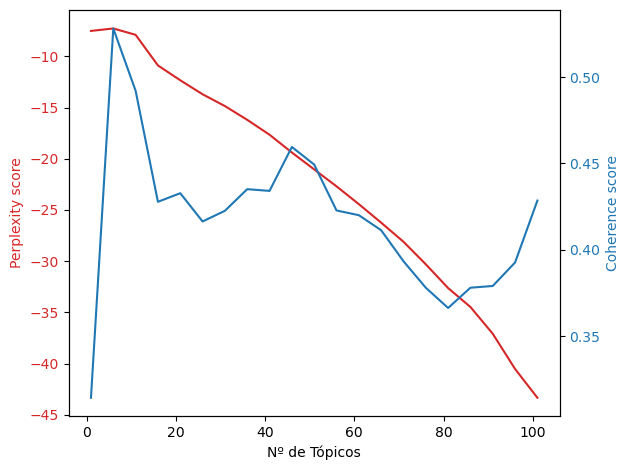

In [41]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('Coherence Score_100 topicos.png')

plt.show()

In [42]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.3142  e valor de perplexidade de -7.5265
A quantidade de tópicos = 6  tem um valor de coerência de  0.5282  e valor de perplexidade de -7.2867
A quantidade de tópicos = 11  tem um valor de coerência de  0.4921  e valor de perplexidade de -7.9076
A quantidade de tópicos = 16  tem um valor de coerência de  0.4278  e valor de perplexidade de -10.8936
A quantidade de tópicos = 21  tem um valor de coerência de  0.4328  e valor de perplexidade de -12.3427
A quantidade de tópicos = 26  tem um valor de coerência de  0.4164  e valor de perplexidade de -13.7093
A quantidade de tópicos = 31  tem um valor de coerência de  0.4226  e valor de perplexidade de -14.8593
A quantidade de tópicos = 36  tem um valor de coerência de  0.4351  e valor de perplexidade de -16.2028
A quantidade de tópicos = 41  tem um valor de coerência de  0.4341  e valor de perplexidade de -17.6578
A quantidade de tópicos = 46  tem um valor de coerência de  0.4596  e

In [43]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=21,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [13:06<00:00, 39.34s/it]


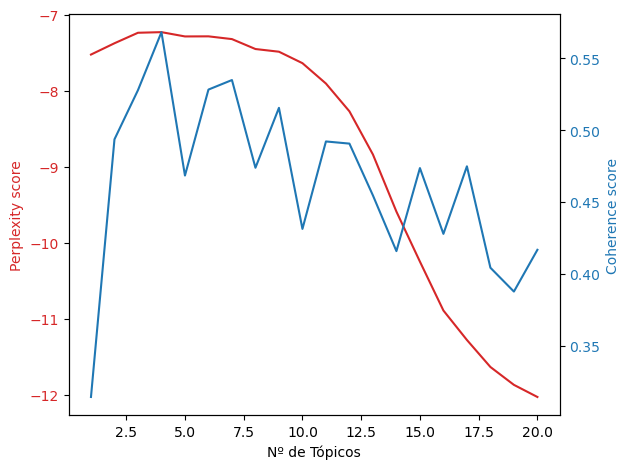

In [44]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=21; start=1; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_MG_Coherence Score_20 topicos.png')

plt.show()

In [45]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.3142  e valor de perplexidade de -7.5265
A quantidade de tópicos = 2  tem um valor de coerência de  0.4936  e valor de perplexidade de -7.3777
A quantidade de tópicos = 3  tem um valor de coerência de  0.5278  e valor de perplexidade de -7.2396
A quantidade de tópicos = 4  tem um valor de coerência de  0.5682  e valor de perplexidade de -7.2315
A quantidade de tópicos = 5  tem um valor de coerência de  0.4684  e valor de perplexidade de -7.288
A quantidade de tópicos = 6  tem um valor de coerência de  0.5282  e valor de perplexidade de -7.2867
A quantidade de tópicos = 7  tem um valor de coerência de  0.5349  e valor de perplexidade de -7.323
A quantidade de tópicos = 8  tem um valor de coerência de  0.4738  e valor de perplexidade de -7.4535
A quantidade de tópicos = 9  tem um valor de coerência de  0.5155  e valor de perplexidade de -7.4889
A quantidade de tópicos = 10  tem um valor de coerência de  0.4312  e valor de perpl

In [46]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=41,
                                                                           limit=56,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [10:31<00:00, 42.07s/it]


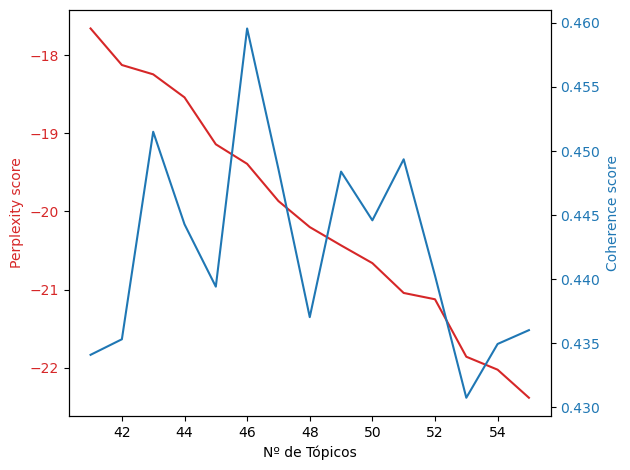

In [47]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=56; start=41; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_MG_Coherence Score_40 a 55 topicos.png')

plt.show()

In [48]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 41  tem um valor de coerência de  0.4341  e valor de perplexidade de -17.6578
A quantidade de tópicos = 42  tem um valor de coerência de  0.4353  e valor de perplexidade de -18.1255
A quantidade de tópicos = 43  tem um valor de coerência de  0.4515  e valor de perplexidade de -18.245
A quantidade de tópicos = 44  tem um valor de coerência de  0.4443  e valor de perplexidade de -18.5397
A quantidade de tópicos = 45  tem um valor de coerência de  0.4394  e valor de perplexidade de -19.1404
A quantidade de tópicos = 46  tem um valor de coerência de  0.4596  e valor de perplexidade de -19.3905
A quantidade de tópicos = 47  tem um valor de coerência de  0.4486  e valor de perplexidade de -19.8668
A quantidade de tópicos = 48  tem um valor de coerência de  0.437  e valor de perplexidade de -20.1998
A quantidade de tópicos = 49  tem um valor de coerência de  0.4484  e valor de perplexidade de -20.434
A quantidade de tópicos = 50  tem um valor de coerência de  0.4446 

In [64]:
# Valor escolhido para coherence score foi 9 tópicos (coherence score = 0.5155).
# Número de tópicos
num_topicos = 9

In [65]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [66]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('min', 0.0646983), ('geral', 0.064078465), ('art', 0.05502297), ('secret', 0.04598531), ('faculdad', 0.021831304), ('publ', 0.015831117), ('administraca', 0.015100746), ('lei', 0.014714748), ('tur', 0.013790347), ('vid', 0.013635527)]
Topic 1: [('escol', 0.19681191), ('caix', 0.06840461), ('norm', 0.04360871), ('joa', 0.026912726), ('letr', 0.022459034), ('tribun', 0.01873232), ('ros', 0.017391952), ('mel', 0.014423734), ('oliv', 0.014264088), ('august', 0.012391897)]
Topic 2: [('lei', 0.040789135), ('receit', 0.018744342), ('estad', 0.014499599), ('orga', 0.01425585), ('artig', 0.013146362), ('execu', 0.012163785), ('credit', 0.010959748), ('fic', 0.01002501), ('entidad', 0.009155575), ('ser', 0.009011885)]
Topic 3: [('sao', 0.1471444), ('paul', 0.11843485), ('vicent', 0.062239453), ('sociedad', 0.059380494), ('colegi', 0.028010923), ('conferenc', 0.023529861), ('jos', 0.021973815), ('reil', 0.02141931), ('seguranc', 0.021154672), ('regul', 0.020461118)]
Topic 4: [('carl', 

### Visualizações:

In [67]:
# Visualização dos tópicos:
visualizacao_legis_MG = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [68]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_legis_MG, r"Legislacao_1934_a_1989_9_topicos.html")

### Distribuição de palavras por frase:

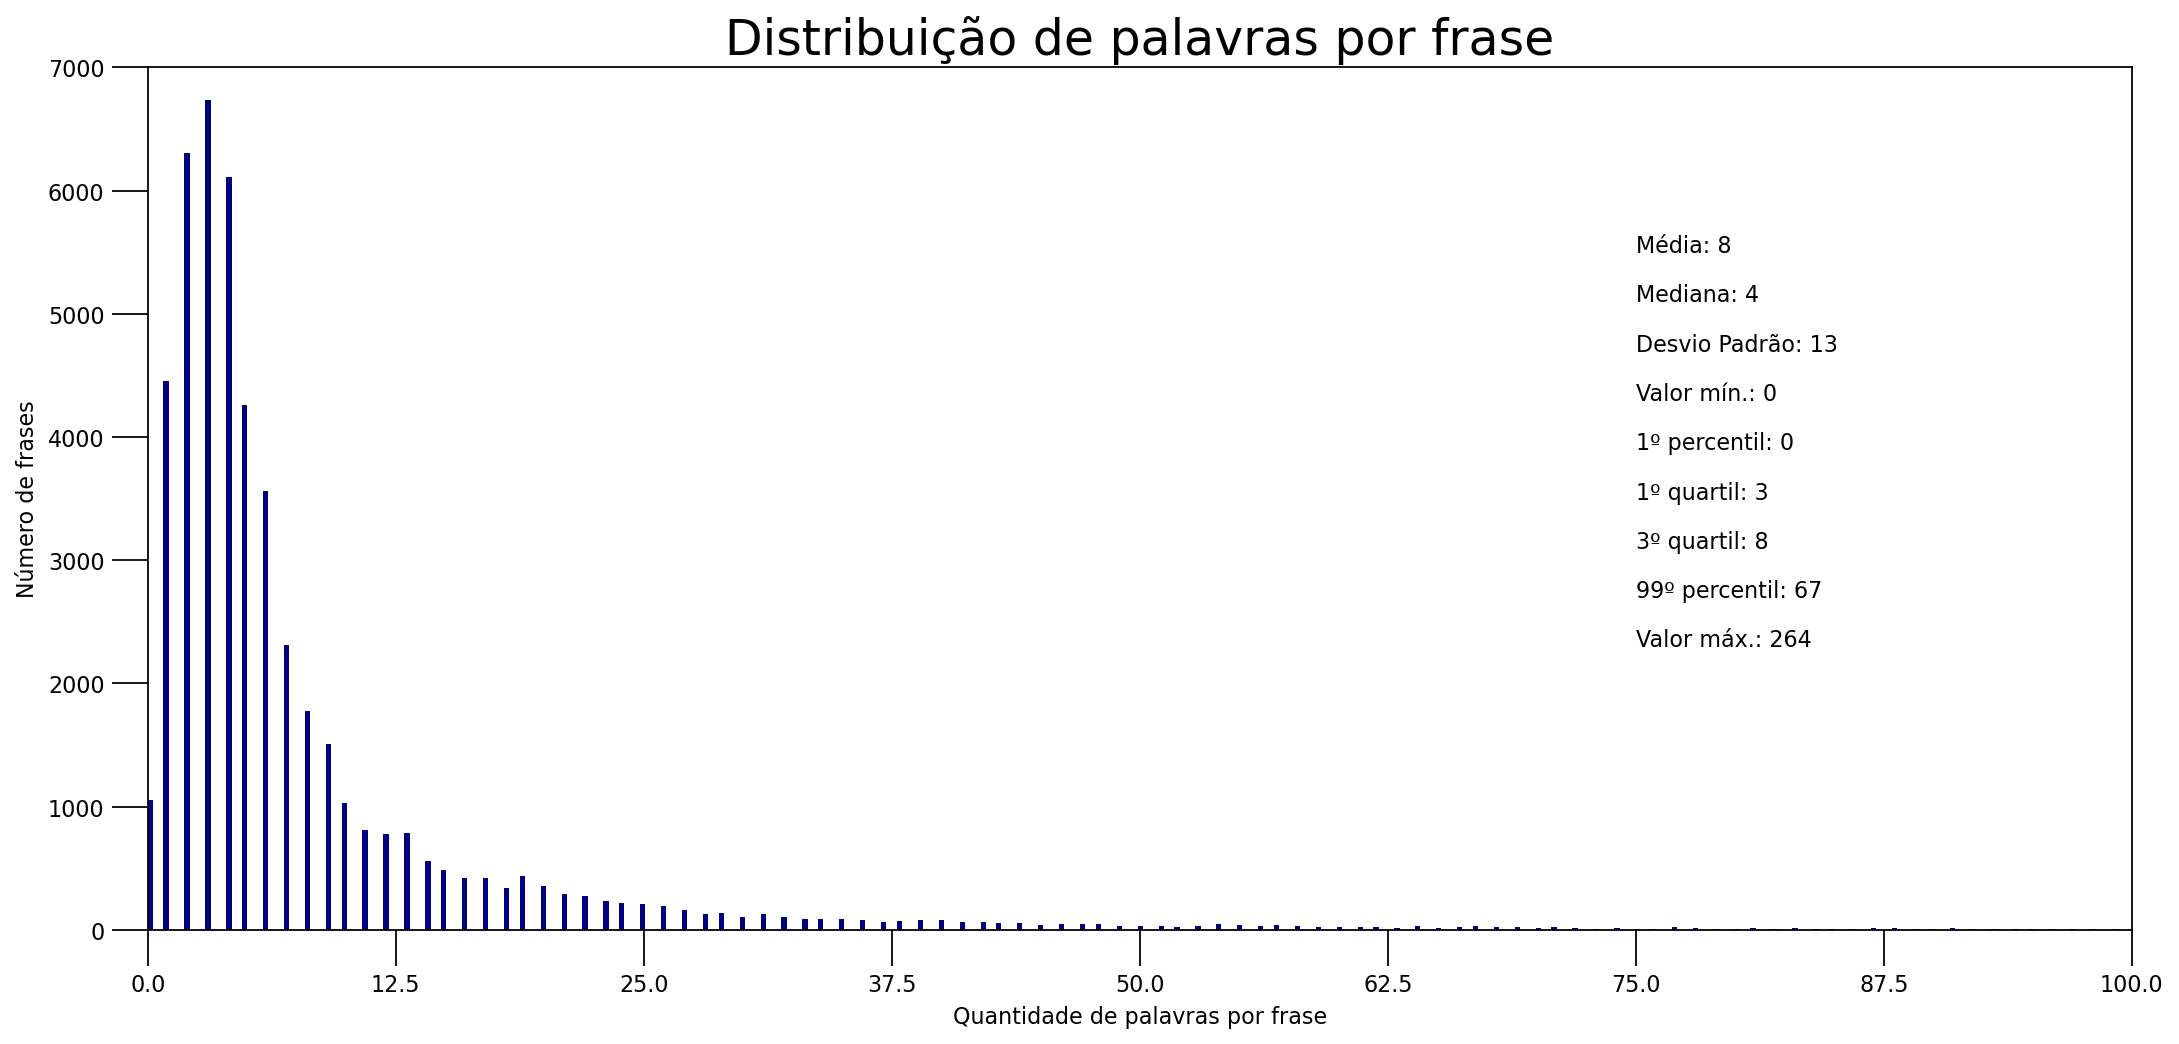

In [71]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(75, 5500, "Média: " + str(round(np.mean(doc_lens))))
plt.text(75, 5100, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(75, 4700, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(75, 4300, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(75, 3900, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(75, 3500, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(75, 3100, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(75, 2700, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(75, 2300, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 100), ylim=(0, 7000), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.yticks(np.linspace(0,7000,8))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [72]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

,Palavra,Frequência
0,escol,6913
1,estud,6567
2,bols,6288
3,sao,5819
4,lei,5591
5,art,5176
6,mar,4510
7,paul,4174
8,caix,3648
9,vicent,3567


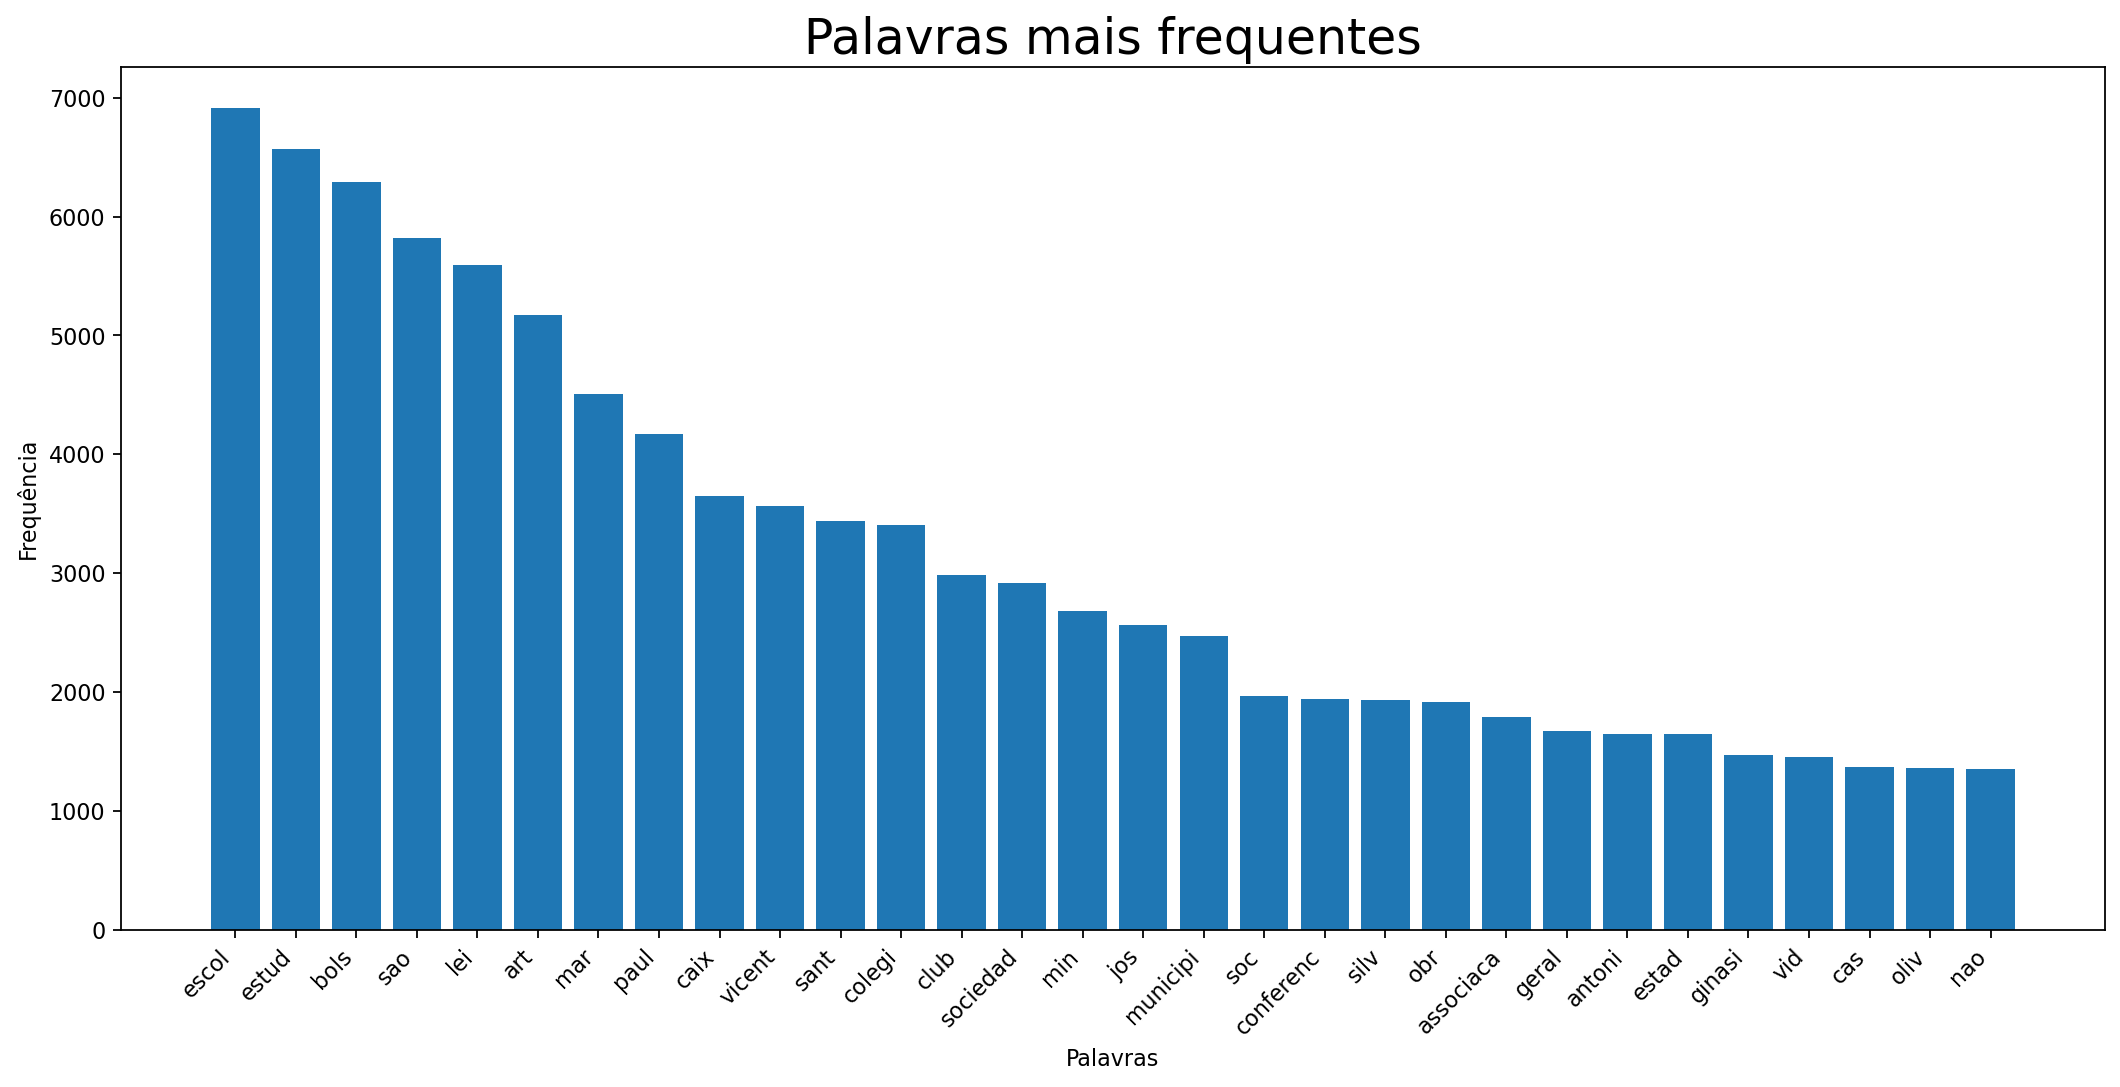

In [73]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

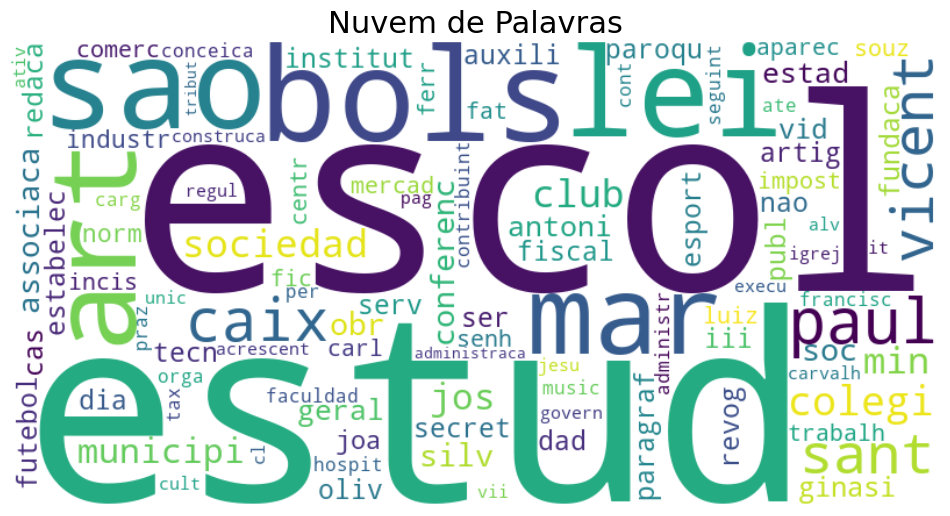

In [74]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [75]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_12316\3273061655.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_12316\3273061655.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_12316\3273061655.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_12316\3273061655.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

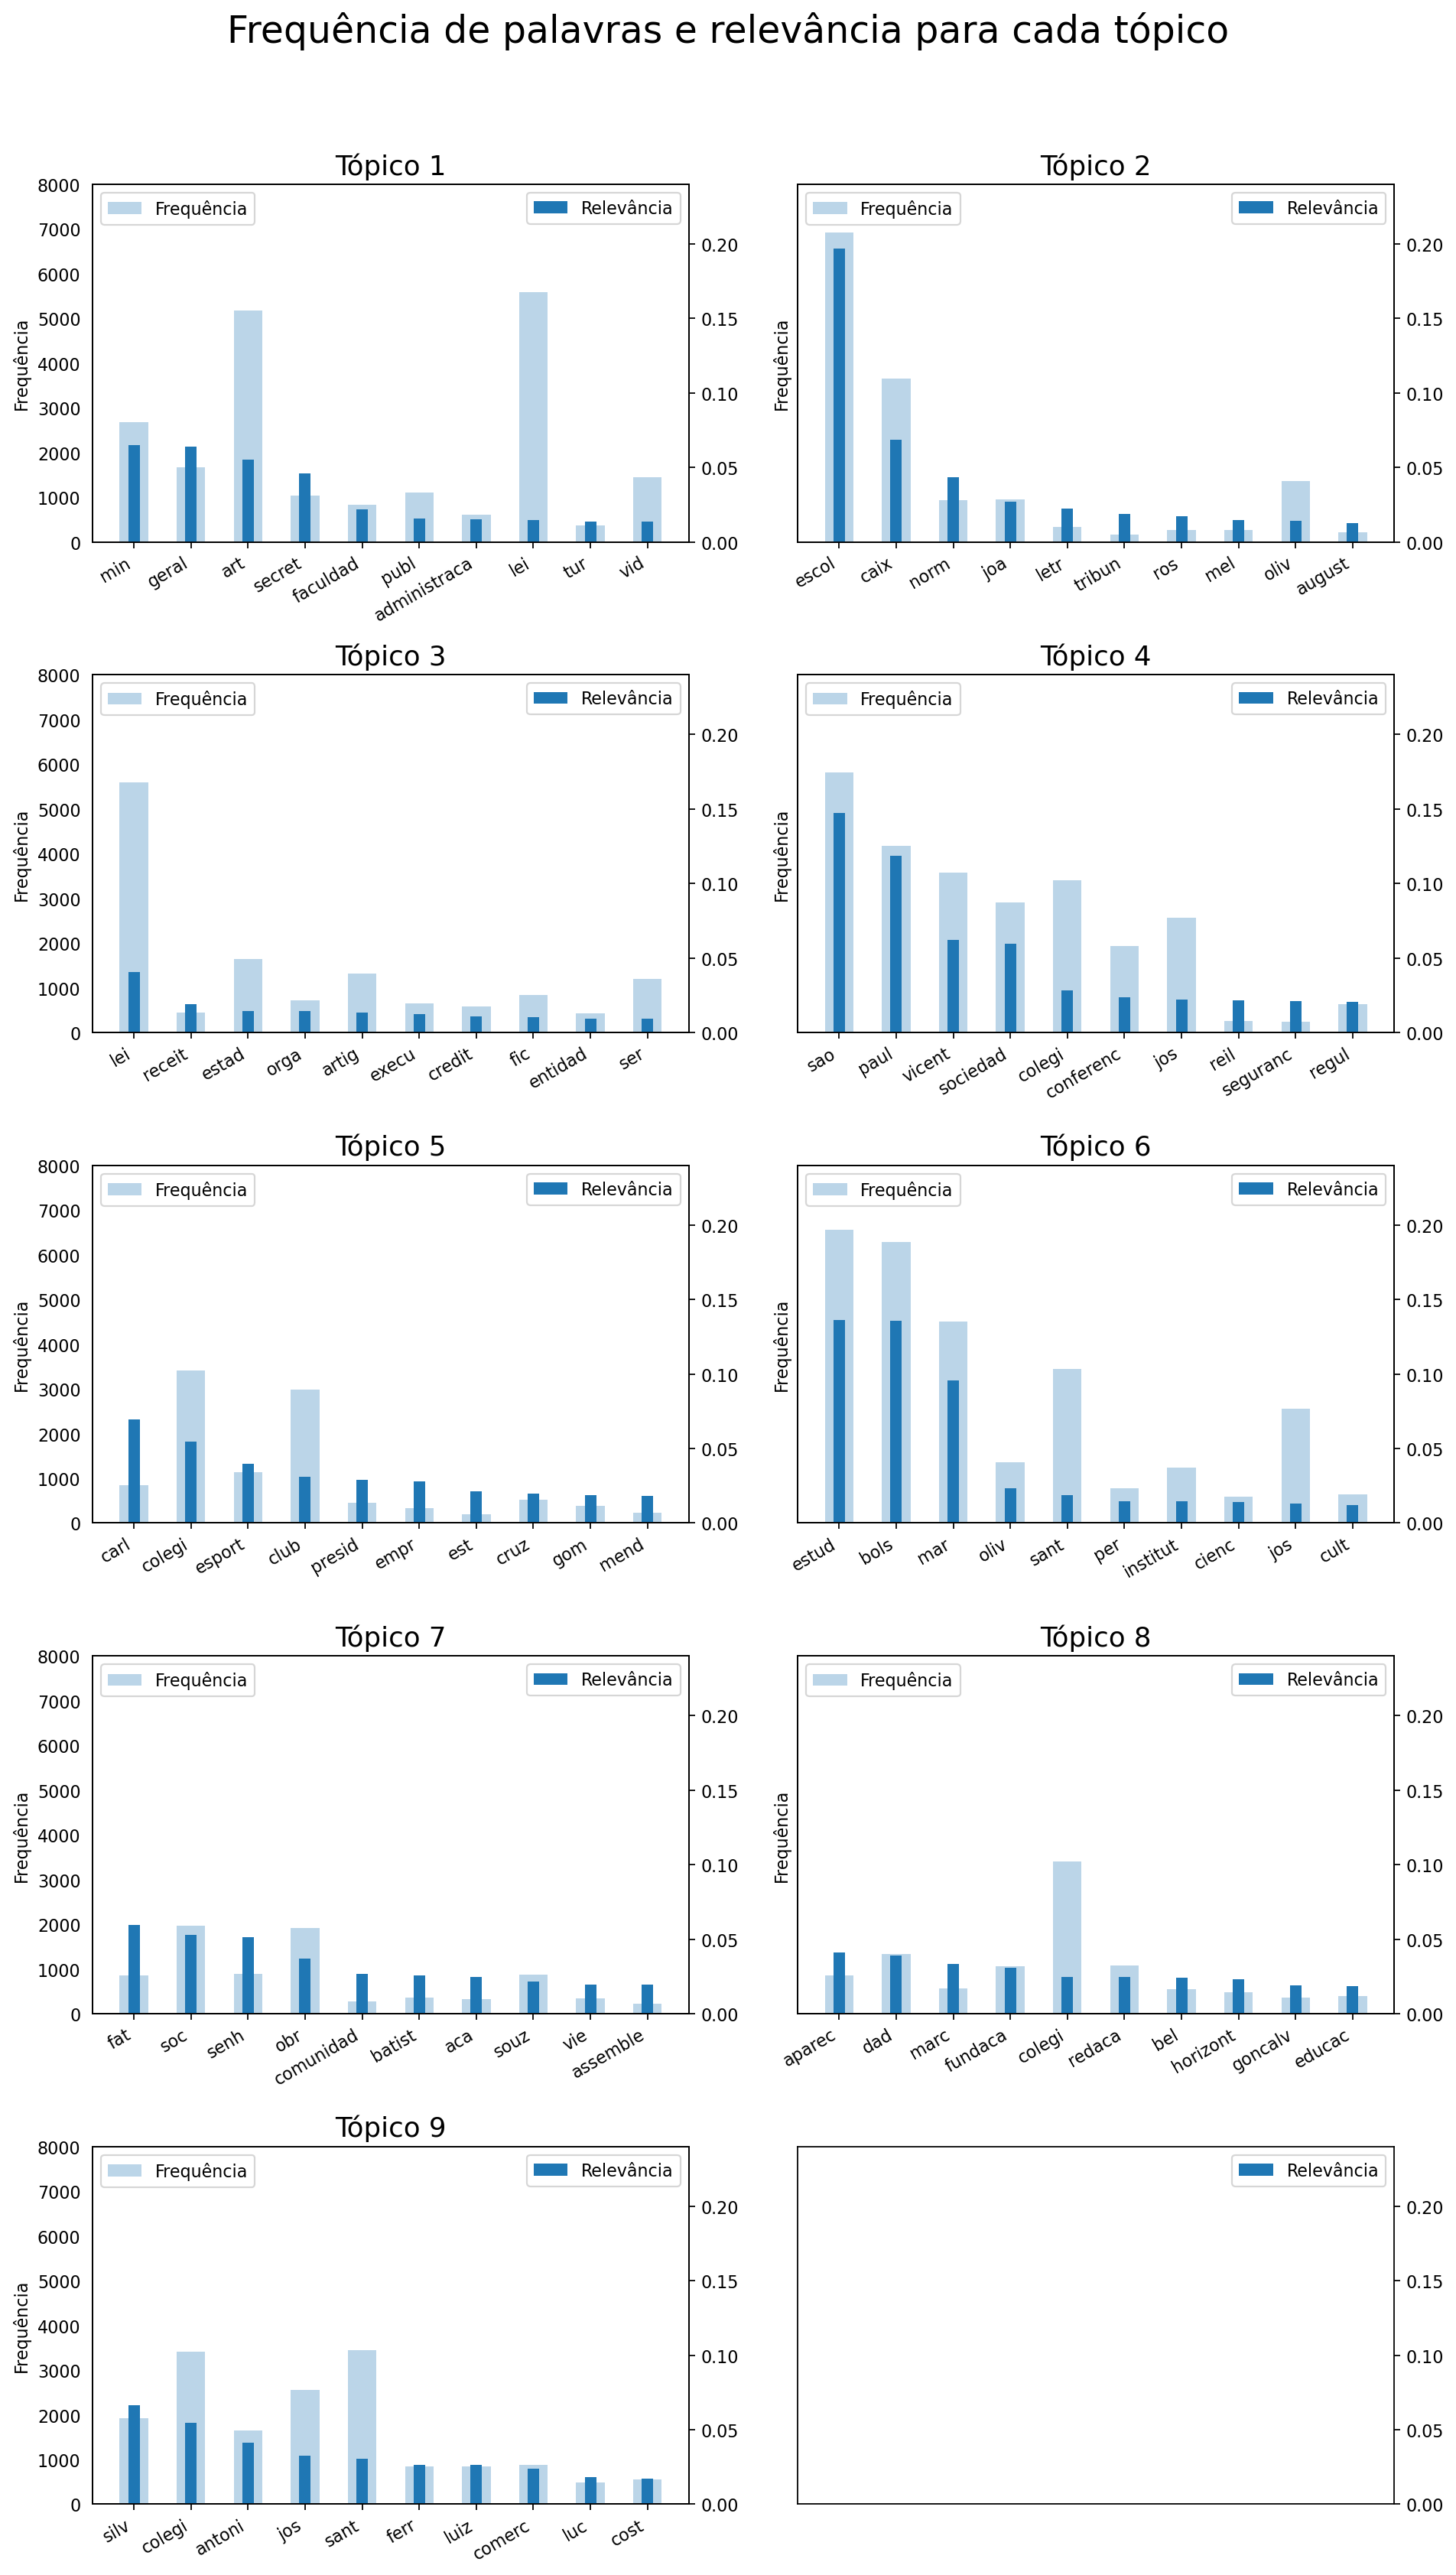

In [80]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(5, 2, figsize=(12,20), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.240); ax.set_ylim(0, 8000)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 10º subplot (na 5ª linha e 2ª coluna):
fig.delaxes(axes[4, 1])
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

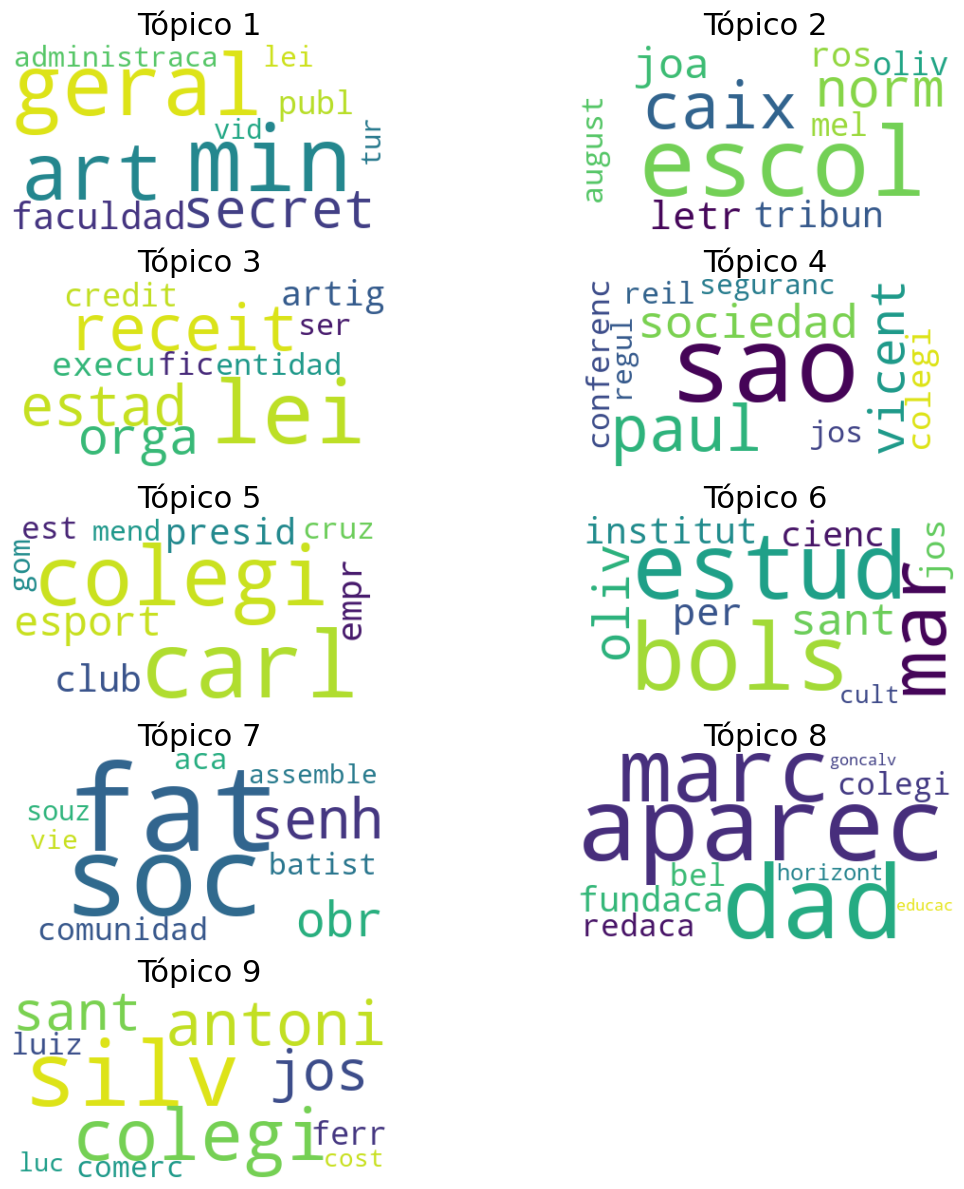

In [79]:
# Configuração do layout dos subplots
num_linhas = 5
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12, 12)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=22))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_1934_a_1989_Nuvem de palavras por topico.png')

plt.show()